In [1]:
import os
import glob
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import operator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# get feature
train_feat, test_feat = [], []
for line in open("./data/features_train/features_resnet1000_train.csv"):
    l = line.strip().split(",")
    train_feat.append(l)
train_feat = np.array(train_feat)
for line in open("./data/features_test/features_resnet1000_test.csv"):
    l = line.strip().split(",")
    test_feat.append(l)
test_feat = np.array(test_feat)

In [2]:
total_word_dict = {}
def get_word_dict(path):
    for filename in glob.glob(os.path.join(path, "*.txt")):
        with open(filename, "r") as content_file:
            content = content_file.read()
            # Lowercase all of the words
            content = np.char.lower(content)

            # Stripping Punctuation
            content = re.sub('[^\w\s]', ' ', str(content))

            # Lemmatizing & Remove Stop Words
            stemmer = PorterStemmer()
            for word in content.split():
                try:
                    if word not in stopwords.words("english"):
                        w = stemmer.stem(word)
                        if w in total_word_dict:
                            total_word_dict[w] += 1
                        else:
                            total_word_dict[w] = 1
                except:
                    pass
get_word_dict("./data/descriptions_train/")

In [3]:
word_dict = {}
def process_des(path, thresh):
    index = 0
    for w in total_word_dict:
        if total_word_dict[w] > thresh:
            word_dict[w] = index
            index += 1  
    
    des_vec = {}
    for filename in glob.glob(os.path.join(path, "*.txt")):
        with open(filename, "r") as content_file:
            content = content_file.read()
            # Lowercase all of the words
            content = np.char.lower(content)

            # Stripping Punctuation
            content = re.sub('[^\w\s]', ' ', str(content))

            # Lemmatizing & Remove Stop Words
            stemmer = PorterStemmer()
            
            cur = [0] * len(word_dict)
            for word in content.split():
                try:
                    if word not in stopwords.words("english"):
                        w = stemmer.stem(word)
                        if w in word_dict:
                            cur[word_dict[w]] += 1
                except:
                    pass
            des_vec[filename.split('/')[-1]] = cur
    return des_vec

thresh = 100
train_des = process_des("./data/descriptions_train/", thresh)
test_des = process_des("./data/descriptions_test/", thresh)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
X = []
y = []
for k in train_des:
    X.append(train_des[k])
    y.append(k)
X = np.array(X)
y = np.array(y)
knn.fit(X, y)
#p = knn.predict(test_des["0.txt"])
#print(p)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [5]:
# names: a list of strings(imagenames)
# train_feat: a matix of featvectors in training set
# Return an aggregated feature derived from k  
train_feat_dict = {}
for i  in range(len(train_feat)):
    name = int(train_feat[i][0].split("/")[1].split(".")[0])
    train_feat_dict[name] = np.array(train_feat[i][1:], dtype=float)

def get_arg_feat(name, train_feat):
    res = train_feat_dict[name]
    return res

def get_score(feat1, feat2):
    feat1 = np.array(feat1, dtype=float)
    feat2 = np.array(feat2, dtype=float)
    return np.linalg.norm(feat1 - feat2)

def get_20_images(target_feat, feats):
    feat_score = {}
    for f in feats:
        name = f[0,].split("/")[1]
        score = get_score(target_feat, f[1:])
        feat_score[name] = score
    #sorted_feat_score = sorted(feat_score.items(), key=operator.itemgetter(1), reverse=True)
    sorted_feat_score = sorted(feat_score.items(), key=operator.itemgetter(1))
    res = []
    for i in range(20):
        res.append(sorted_feat_score[i][0])
    res = np.array(res)
    return res;

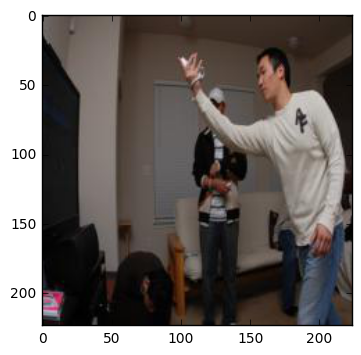

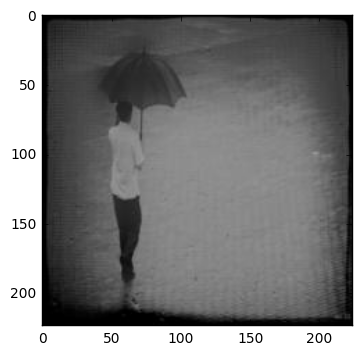

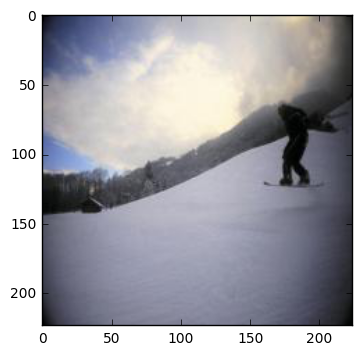

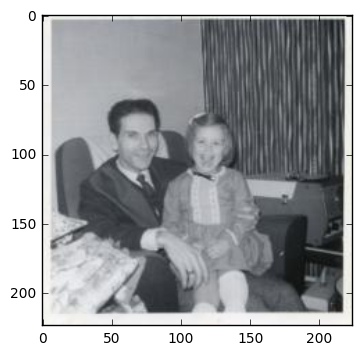

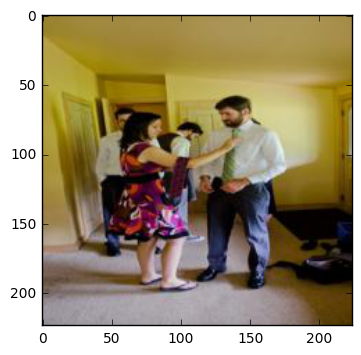

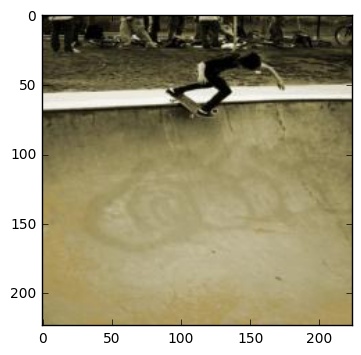

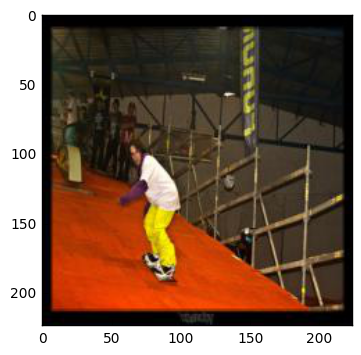

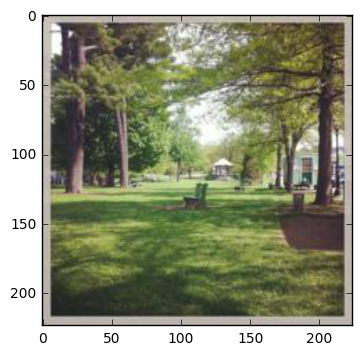

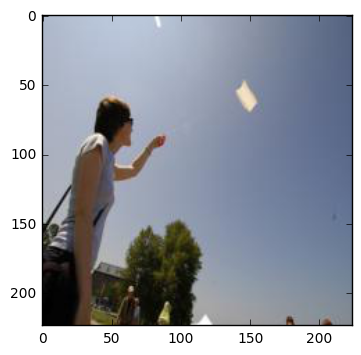

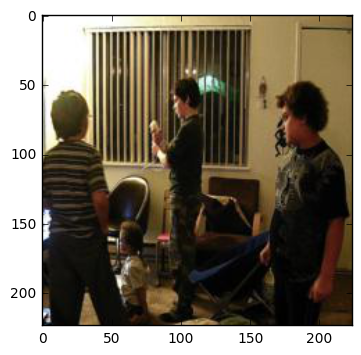

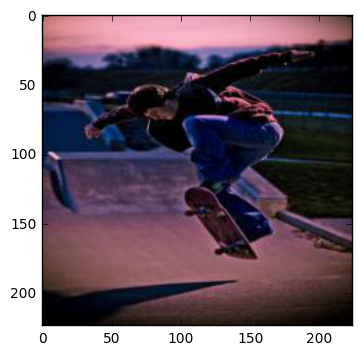

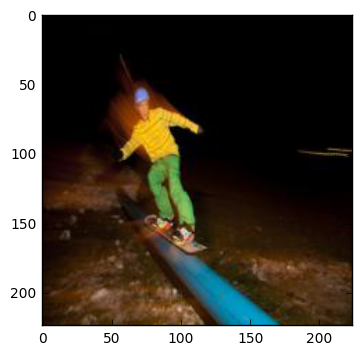

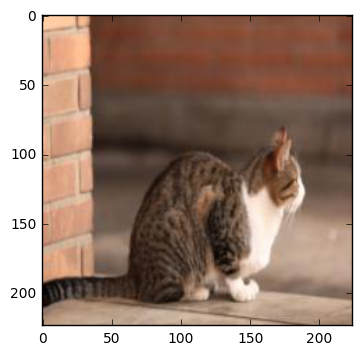

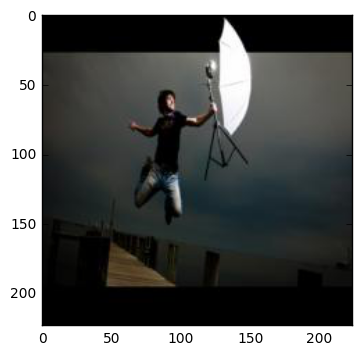

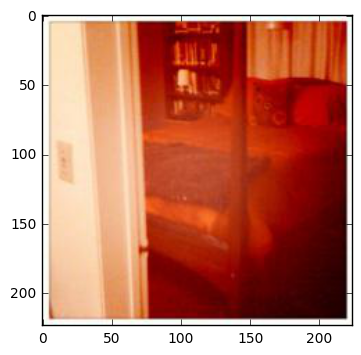

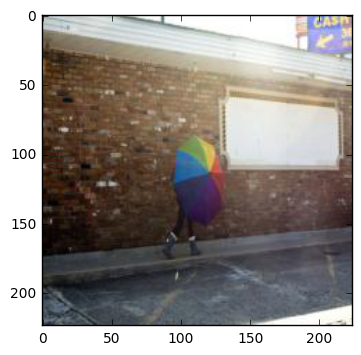

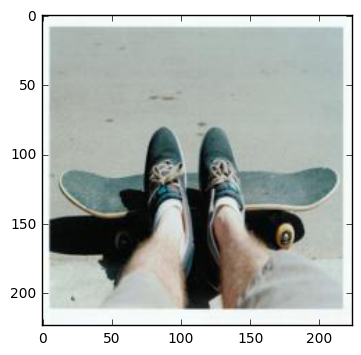

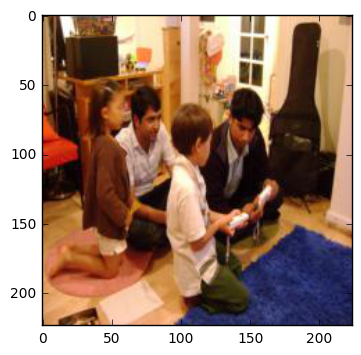

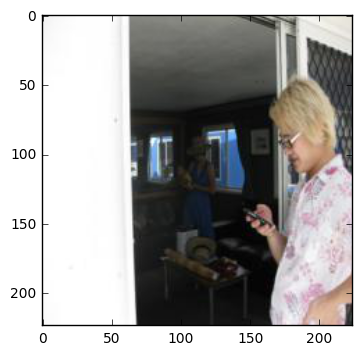

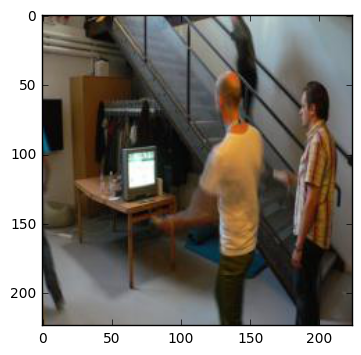

In [8]:
# des be like "0.txt"
def predict(des):
    d = np.array(test_des[des])
    pred = knn.predict(d.reshape(1, -1))
    pred_int = int(pred[0].split(".")[0])
    agg = get_arg_feat(pred_int, train_feat)
    top_20 = get_20_images(agg, test_feat)
    return top_20

def show_20_images(top_20):
    for i in top_20:
        img = Image.open("./data/images_test/" + i)
        img = np.asarray(img)
        plt.imshow(img)
        plt.show()

top = predict("5.txt")
show_20_images(top)

In [9]:
import csv
import time

submission = []
def kaggle():
    submission = []
    submission.append(["Descritpion_ID", "Top_20_Image_IDs"])
    count = 0
    for d in test_des:
        if count % 50 == 0:
            print(count)
        line = []
        line.append(d)
        top_20 = " ".join(predict(d))
        line.append(top_20)
        submission.append(line)
        count += 1
    with open("kaggle0.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(submission)

start_time = time.time()
kaggle()
print("--- %s seconds ---" % (time.time() - start_time))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
--- 2307.5368678569794 seconds ---
